# Denoising Tutorial (OPM Data)

### Robert Seymour, Wellcome Centre for Human Neuroimaging, June 2020

#### Denoising Techniques:

- Synthetic Gradiometry
- Detrending
- Spectral Interpolation
- Zapline

## Add toolboxes to your MATLAB path
To download NoiseTools, please see: http://audition.ens.fr/adc/NoiseTools/

In [ ]:
%% Paths (RS)
fieldtripDir    = '/Users/rseymoue/Documents/scripts/fieldtrip-20191213';
script_dir      = '/Users/rseymoue/Documents/GitHub/analyse_OPMEG';
denoise_dir     = '/Users/rseymoue/Documents/scripts/NoiseTools';
data_dir        = '/Volumes/Robert T5/OPM_data/benchmarking_26_02/';
save_dir        = '/Users/rseymoue/Documents/GitHub/opm_benchmarking_feb_2020/';

% Add Fieldtrip to path
disp('Adding Fieldtrip, NoiseTools and analyse_OPMEG to your MATLAB path');
addpath(fieldtripDir)
ft_defaults;

% Add analyse_OPMEG Scripts to path
addpath(genpath(script_dir));

% Add NoiseTools to path
addpath(denoise_dir)

% cd to save dir
cd(save_dir)

## Read in the data, select relevent channels, downsample to 600Hz.
#### Note: Usually you wouldn't downsample at this stage, but for time-saving I did!

In [ ]:
% Read in the raw data using BIDS
cfg             = [];
cfg.folder      = data_dir;
cfg.precision   = 'single';
cfg.bids.task   = 'faces';
cfg.bids.sub    = '002';
cfg.bids.ses    = '001';
cfg.bids.run    = '001';
rawData         = ft_opm_create(cfg);

% Select only OPM+REF channels
cfg = [];
cfg.channel = vertcat(ft_channelselection_opm('MEG',rawData),...
    ft_channelselection_opm('MEGREF',rawData));
rawData_MEG_REF         = ft_selectdata(cfg,rawData);

% Select only OPM channels
cfg             = [];
cfg.channel     = ft_channelselection_opm('MEG',rawData);
rawData_MEG     = ft_selectdata(cfg,rawData);

% % Resample to 600Hz to speed things up
cfg                 = [];
cfg.resamplefs      = 600;
[rawData_MEG_REF]   = ft_resampledata(cfg, rawData_MEG_REF);
[rawData_MEG]       = ft_resampledata(cfg, rawData_MEG);


## Synthetic Gradiometry

Synthetic gradiometry involves regressing data acquired from reference OPMs, placed away from the head, from the data acquired from the OPMs of interest, placed on the head. This is thought to remove environmental noise, captured by the reference OPMs, leaving only brain signal!

Following testing, it has been found that filtering the OPM data (data channels and references) is crucial for de-noising. Here we have applied the following filters:

- High-pass at 2Hz (*N.B. if your data has a higher sampling frequency, adjust the cfg.hpfiltord parameter*)
- Low-pass at 100Hz 
- Band-pass between 115-125Hz to remove high amplitude opti-track artefact
- Band-pass between 98-102Hz to remove 100Hz line-noise harmonic

When performing the synthetic gradiometry, we have opted to further filter the reference data between 2-30Hz, 30-40Hz, 40-60Hz and 60-80Hz. This has been shown to more effectively remove sharp peaks in the PSD. 

In this tutorial, we are using a "window-ed" approach, whereby gradiometry is applied on overlapping windows of data, rather than the entire dataset. Following, testing the optimal window-size is around 50-100s.


In [ ]:
% High-pass filter at 2Hz to remove low-frequency drift
cfg             = [];
cfg.hpfilter    = 'yes';
cfg.hpfreq      = 2;
data_filt         = ft_preprocessing(cfg,rawData_MEG_REF);

% Low-pass filter at 100Hz
cfg             = [];
cfg.lpfilter    = 'yes';
cfg.lpfreq      = 100;
data_filt         = ft_preprocessing(cfg,data_filt);

% Band-stop filter to remove the large 120Hz peaks
cfg             = [];
cfg.bsfilter    = 'yes';
cfg.bsfreq      = [115 125];
data_filt       = ft_preprocessing(cfg,data_filt);

% Band-stop filter to remove the large 100Hz peak
cfg             = [];
cfg.bsfilter    = 'yes';
cfg.bsfreq      = [98 102];
data_filt       = ft_preprocessing(cfg,data_filt);


In [ ]:
% Synthetic Gradiometry Using Window-ed Approach
cfg                 = [];
cfg.channel         = vertcat(ft_channelselection_opm('MEG',rawData),...
    '-N0-TAN','-N4-TAN','-N3-TAN','-MV-TAN','-N0-RAD','-N4-RAD',...
    '-N3-RAD','-MV-RAD');
cfg.refchannel      = ft_channelselection_opm('MEGREF',rawData);
cfg.filter_ref      = [2 30; 30 40; 40 60;60 80];
cfg.derivative      = 'yes';
cfg.return_all      = 'no';
cfg.winsize         = 100;
data_synth_grad     = ft_opm_synth_gradiometer_window(cfg,data_filt);


Calculating PSD for ALL channels
the call to "ft_selectdata" took 0 seconds and required the additional allocation of an estimated 97 MB
the call to "ft_selectdata" took 0 seconds and required the additional allocation of an estimated 0 MB


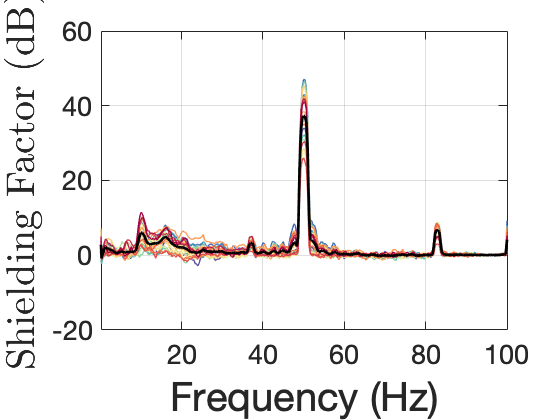

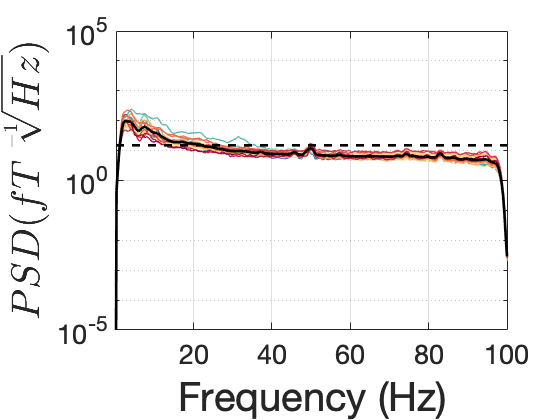

In [11]:
cfg                 = [];
cfg.channel         = 'all';
cfg.trial_length    = 3;
cfg.method          = 'tim';
cfg.foi             = [0.2 100];
cfg.plot            = 'yes';
cfg.plot_legend     = 'no';
pow                 = ft_opm_psd(cfg,data_synth_grad);

cfg                 = [];
cfg.channel         = data_synth_grad.label;
cfg.trial_length    = 3;
cfg.method          = 'tim';
cfg.foi             = [0.2 100];
cfg.plot            = 'yes';
cfg.plot_legend     = 'no';
pow                 = ft_opm_psd_compare(cfg,data_filt,data_synth_grad);

## Robust Detrending

In cases where high-pass filtering is not advisable (e.g. certain ERF analyses, decoding etc.), removal of low-frequency drift can be achieved using detrending.

Please see Cheveigné & Arzounian (2018) https://doi.org/10.1016/j.neuroimage.2018.01.035 for details of this method. It is very similar to other polynomial removal methods, but is also *robust* to sensor railing, has the ability to detrend over overlapping windows.

Here, we are using overlapping 1 second windows and removing 10 polynomials. This is an unusually small window size, but there is *lots* of low-frequency noise in this particular dataset. Please adjust the cfg.poly_num and cfg.winsize for your own data. This procedure takes a while, so go make a coffee.

After it is completed, we can see the low-frequency drift has been removed from the data :) **You can then apply the same synthetic gradiometry pipeline as above, but ignoring the high-pass filter step.**

PLEASE NOTE: for the M170 data, only applying detrending (and NO high-pass filter) leads to sub-optimal results (drift still present, lower amplitude ERFs). More testing required! 

In [ ]:
%% De-trending
cfg             = [];
cfg.poly_num    = 10;
cfg.winsize     = 1;
[data_detrend]  = ft_robust_detrend(cfg,rawData_MEG_REF);


the input is raw data with 32 channels and 1 trials
> In fixsampleinfo (line 94)
  In ft_datatype_raw (line 147)
  In ft_checkdata (line 268)
  In ft_databrowser (line 294)
detected   0 visual artifacts
the call to "ft_prepare_layout" took 0 seconds and required the additional allocation of an estimated 0 MB
the call to "ft_prepare_layout" took 0 seconds and required the additional allocation of an estimated 1 MB
the call to "ft_databrowser" took 4 seconds and required the additional allocation of an estimated 161 MB


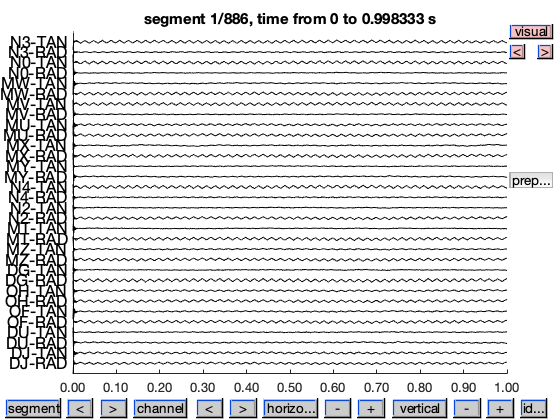

In [13]:
% Plot the raw data
cfg                 = [];
cfg.viewmode        = 'vertical';
cfg.colorgroups     = 'allblack';
cfg.position        = [1 1 1400 600];
ft_databrowser(cfg,data_detrend);


*Of course... the data still looks weird because of the other noise (eg. 50Hz, 120Hz etc.)!*

the call to "ft_selectdata" took 0 seconds and required the additional allocation of an estimated 97 MB
the call to "ft_selectdata" took 0 seconds and required the additional allocation of an estimated 0 MB


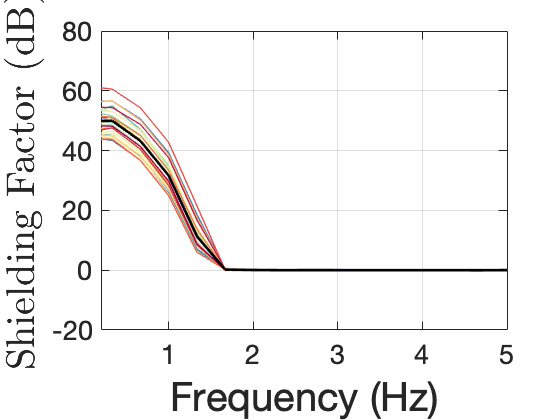

In [15]:
% Compare before and after de-trending
cfg                 = [];
cfg.channel         = data_synth_grad.label;
cfg.trial_length    = 3;
cfg.method          = 'tim';
cfg.foi             = [0.2 5];
cfg.plot            = 'yes';
cfg.plot_legend     = 'no';
pow                 = ft_opm_psd_compare(cfg,rawData_MEG_REF,data_detrend);


## Spectral Interpolation for Line Noise and Other Spectral Peaks

Based on the method from *Leske, S., & Dalal, S. S. (2019). Reducing power line noise in EEG and MEG data via spectrum interpolation. NeuroImage, 189, 763-776* It works as follows: 

**1. Transform the time domain signal into the frequency domain via a discrete Fourier transform (DFT)**

**2. Remove the line noise component in the amplitude spectrum by interpolating the curve at interference frequency according to neighbouring frequencies**

**3. Transform the data back into the time domain via an inverse discrete Fourier transform (iDFT).
When using spectral interpolation through ft_preprocessing, the key parameters are:**

```matlab
- cfg.dftbandwidth      = width of the frequencies considered "noise"
- cfg.dftneighbourwidth = width of the neighbouring frequencies considered for the mean. 
```

So say we use wish to remove the 50Hz line noise using cfg.dftfreq = 50;

- A value of dftbandwidth = 2, would equate to 50±1Hz (i.e. 49-51Hz). 
- A value of cfg.dftneighbourwidth = 2, woudld equate to interpolating using the mean of 47-49Hz and 51-53Hz.

#### For illustrative purposes, we shall remove the remaining 50Hz line-noise peak, using the data after synthetic gradiometry:

Calculating PSD for ALL channels


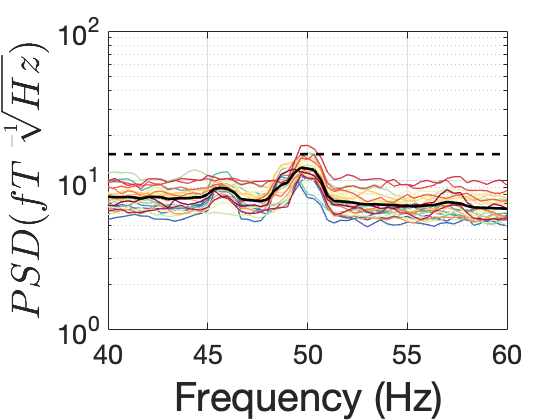

In [23]:
cfg                     = [];
cfg.channel             = 'all';
cfg.trial_length        = 3;
cfg.method              = 'tim';
cfg.foi                 = [40 60];
cfg.plot                = 'yes';
cfg.plot_legend         = 'no';
pow                     = ft_opm_psd(cfg,data_synth_grad);

*Note how there is still a small peak at 50Hz, which could affect our data analysis. We could remove this using a band-stop filter, but also risk edge artefacts, filter ringing etc.*

In [20]:
%% Spectral Interpolation
cfg                     = [];
cfg.channel             = 'all';
cfg.dftfilter           = 'yes';
cfg.dftfreq             = [50];
cfg.dftreplace          = 'neighbour';
cfg.dftbandwidth        = [3];
cfg.dftneighbourwidth   = [2];
data_synth_grad_si      = ft_preprocessing(cfg,data_synth_grad);


the call to "ft_selectdata" took 0 seconds and required the additional allocation of an estimated 0 MB
preprocessing
preprocessing trial 1 from 1
the call to "ft_preprocessing" took 2 seconds and required the additional allocation of an estimated 0 MB


Calculating PSD for ALL channels
Calculating PSD for ALL channels
Calculating PSD for ALL channels


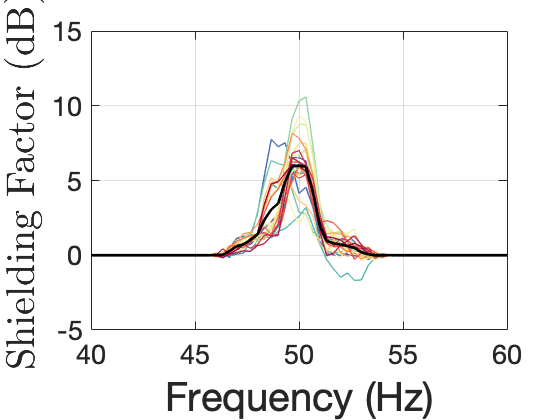

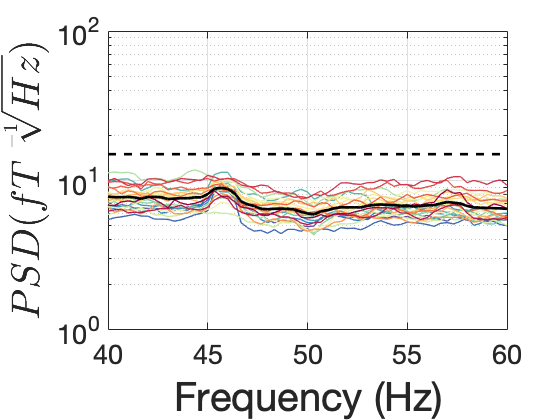

In [29]:
cfg                     = [];
cfg.channel             = 'all';
cfg.trial_length        = 3;
cfg.method              = 'tim';
cfg.foi                 = [40 60];
cfg.plot                = 'yes';
cfg.plot_legend         = 'no';
pow                     = ft_opm_psd(cfg,data_synth_grad_si);

cfg                     = [];
cfg.channel             = 'all';
cfg.trial_length        = 3;
cfg.method              = 'tim';
cfg.foi                 = [40 60];
cfg.plot                = 'yes';
cfg.plot_legend         = 'no';
pow                     = ft_opm_psd_compare(cfg,data_synth_grad,data_synth_grad_si);

*We have successfully removed the 50Hz peak :)*

## Zapline

the call to "ft_selectdata" took 0 seconds and required the additional allocation of an estimated 0 MB


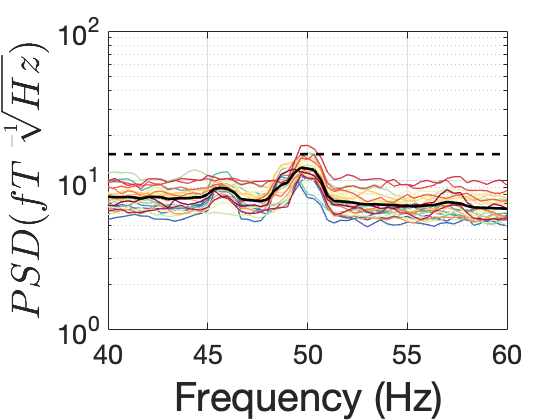

In [26]:
cfg                 = [];
cfg.channel         = data_synth_grad.label;
cfg.trial_length    = 3;
cfg.method          = 'tim';
cfg.foi             = [40 60];
cfg.plot            = 'yes';
cfg.plot_legend     = 'no';
pow                 = ft_opm_psd(cfg,data_synth_grad);

In [ ]:
cfg                 = [];
cfg.ln_freq         = 50;
cfg.n_remove        = 2;
cfg.winsize         = 5;
cfg.truncate_PC     = [];
data_zapped         = ft_zapline_window(cfg,data_synth_grad);

the call to "ft_selectdata" took 0 seconds and required the additional allocation of an estimated 0 MB
the call to "ft_selectdata" took 0 seconds and required the additional allocation of an estimated 0 MB
the call to "ft_selectdata" took 0 seconds and required the additional allocation of an estimated 0 MB


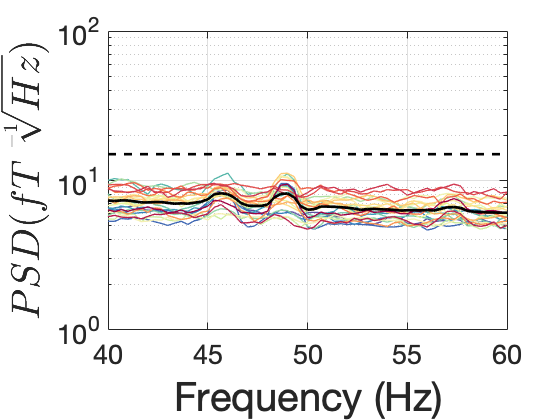

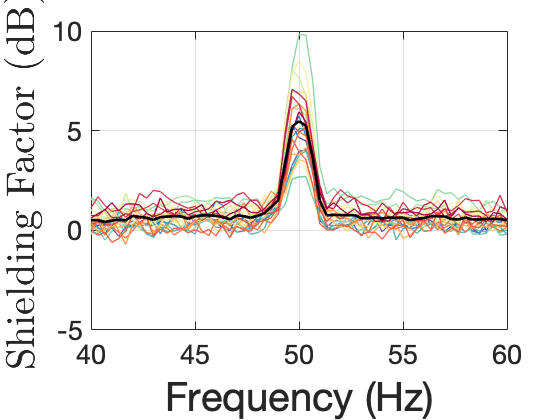

In [30]:
cfg                 = [];
cfg.channel         = data_synth_grad.label;
cfg.trial_length    = 3;
cfg.method          = 'tim';
cfg.foi             = [40 60];
cfg.plot            = 'yes';
cfg.plot_legend     = 'no';
pow                 = ft_opm_psd_compare(cfg,data_synth_grad,data_zapped);

cfg                 = [];
cfg.channel         = data_synth_grad.label;
cfg.trial_length    = 3;
cfg.method          = 'tim';
cfg.foi             = [40 60];
cfg.plot            = 'yes';
cfg.plot_legend     = 'no';
pow                 = ft_opm_psd(cfg,data_zapped);

# DSSP
### WORK IN PROGRESS

In [ ]:
load([data_dir 'headmodel.mat']);
load([data_dir 'sourcemodel3d.mat']);

% Prepare Leadfield

disp('Preparing Leadfield');
cfg             = [];
cfg.method      ='lcmv';
cfg.channel     = vertcat(ft_channelselection_opm('MEG',rawData),...
     '-N0-TAN','-N4-TAN','-N3-TAN','-MV-TAN','-N0-RAD','-N4-RAD',...
     '-N3-RAD','-MV-RAD');
cfg.grid        = sourcemodel3d;
cfg.headmodel   = headmodel;
cfg.grad        = rawData.grad;
cfg.normalize   = 'no' ; %Normalise Leadfield: 'yes' for beamformer
%cfg.normalizeparam  = 1;
lf = ft_prepare_leadfield(cfg);


In [ ]:
cfg                     = [];
cfg.sourcemodel         = lf;
cfg.dssp.n_space        = 23;
cfg.dssp.n_in           = 23;
cfg.dssp.n_out          = 23;
%cfg.dssp.n_intersect    = 0.99;
cfg.winsize             = 50;
rawData_MEG_DSSP        = ft_dssp_window(cfg, data_synth_grad);

the call to "ft_selectdata" took 0 seconds and required the additional allocation of an estimated 0 MB
the call to "ft_selectdata" took 0 seconds and required the additional allocation of an estimated 0 MB
the call to "ft_selectdata" took 0 seconds and required the additional allocation of an estimated 0 MB


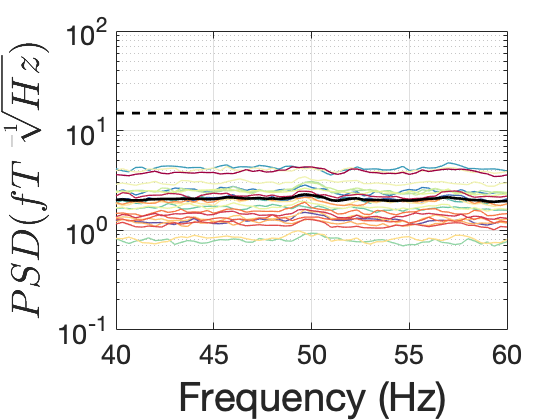

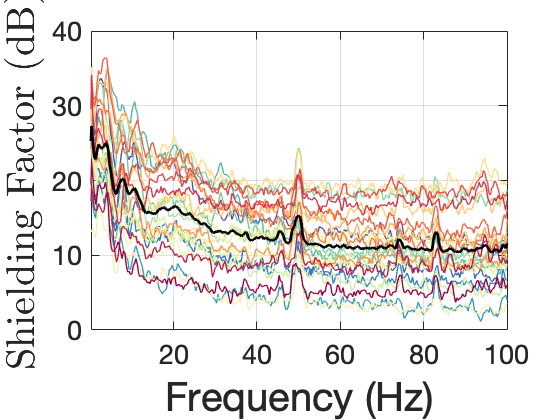

In [40]:
cfg                 = [];
cfg.channel         = data_synth_grad.label;
cfg.trial_length    = 3;
cfg.method          = 'tim';
cfg.foi             = [0.2 100];
cfg.plot            = 'yes';
cfg.plot_legend     = 'no';
pow                 = ft_opm_psd_compare(cfg,data_synth_grad,rawData_MEG_DSSP);

cfg                 = [];
cfg.channel         = data_synth_grad.label;
cfg.trial_length    = 3;
cfg.method          = 'tim';
cfg.foi             = [40 60];
cfg.plot            = 'yes';
cfg.plot_legend     = 'no';
pow                 = ft_opm_psd(cfg,rawData_MEG_DSSP);